In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
%matplotlib inline

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


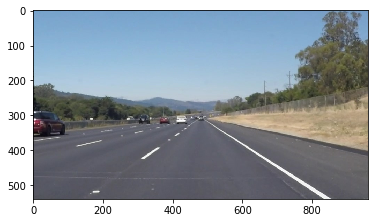

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = rgb2gray(image)  
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
#plt.imshow(gray, cmap='gray')

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transofrmation"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gussian_blur(img, kernel_size):
    """Applies a Gussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    ignore_mask_color = 0
    if (len(img.shape) > 2):
        channel_count = img.shape[2]
        ignore_mask_color = 255 * channel_count # i.e. 3 or 4 depending on your image
    else :
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness= 10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Draw blue line to see the error between original line segments and extrapolate lines.
    #for line in lines:
        #for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 6)
    
    right_line_segments = []
    left_line_segments = []
    top = 325
    bottom = img.shape[0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            abs_slope = np.fabs(slope)
            if (abs_slope < 0.5 or abs_slope > 0.8):
                continue
            #print ("Slope", slope)
            #abs_slope =  math.fabs(slope)
            if (slope < 0.0):
                # Left line segments slope is less than 0
                left_line_segments.append(line)
            else:
                # Right line segments slope is greater or equal to 0
                right_line_segments.append(line)
    # Drawing Left line 
    left_line_segments_mean = (np.mean(np.array(left_line_segments), axis = 0)).flatten().astype(int)
    left_x1_mean = left_line_segments_mean[0]
    left_y1_mean = left_line_segments_mean[1]
    left_x2_mean = left_line_segments_mean[2]
    left_y2_mean = left_line_segments_mean[3]
    left_slope = (left_y2_mean - left_y1_mean) / (left_x2_mean - left_x1_mean)
    left_y1 = top
    left_y2 = bottom
    left_x1 =  (int)(left_x1_mean + ((left_y1 - left_y1_mean) / left_slope))
    left_x2 =  (int)(left_x1_mean + ((left_y2 - left_y1_mean) / left_slope))
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    #Drawing right line
    right_line_segments_mean = (np.mean(np.array(right_line_segments), axis = 0)).flatten().astype(int)
    right_x1_mean = right_line_segments_mean[0]
    right_y1_mean = right_line_segments_mean[1]
    right_x2_mean = right_line_segments_mean[2]
    right_y2_mean = right_line_segments_mean[3]
    right_slope = (right_y2_mean - right_y1_mean) / (right_x2_mean - right_x1_mean)
    right_y1 = top
    right_y2 = bottom
    right_x1 =  (int)(right_x1_mean + ((right_y1 - right_y1_mean) / right_slope))
    right_x2 =  (int)(right_x1_mean + ((right_y2 - right_y1_mean) / right_slope))
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [5]:
# Build your pipeline to work on the images in the directory "test_images"
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

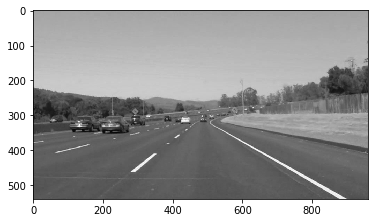

In [6]:
img = mpimg.imread("test_images/solidWhiteCurve.jpg")
orig_img_copy = np.copy(img)
# Convert image into grayscale and save it in the output images directory.
gray_img = grayscale(img)
plt.imshow(gray_img, cmap='gray')
mpimg.imsave("output_images_solidWhiteCurve/gray.jpg", gray_img)

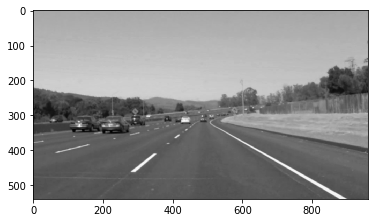

In [7]:
gussian_blur_img = gussian_blur(gray_img, 5)
plt.imshow(gussian_blur_img, cmap='gray')
mpimg.imsave("output_images_solidWhiteCurve/blurGray.jpg", gussian_blur_img)

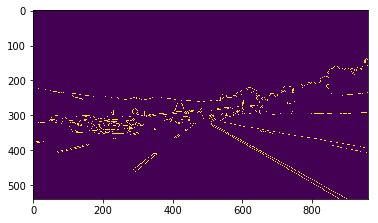

In [8]:
canny_edges_img = canny(gussian_blur_img, 50, 150)
plt.imshow(canny_edges_img)
mpimg.imsave("output_images_solidWhiteCurve/canny.jpg", canny_edges_img)

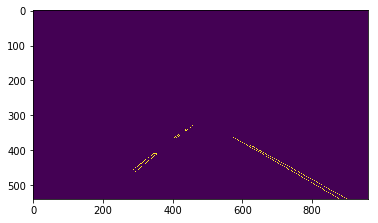

In [9]:
imshape = canny_edges_img.shape
vertices = np.array([[(0, imshape[0]), (440, 325),  (490, 325), (imshape[1], imshape[0])]], dtype = np.int32)
region_masked_img = region_of_interest(canny_edges_img, vertices)
plt.imshow(region_masked_img)
mpimg.imsave("output_images_solidWhiteCurve/regionMaskedImage.jpg", region_masked_img)

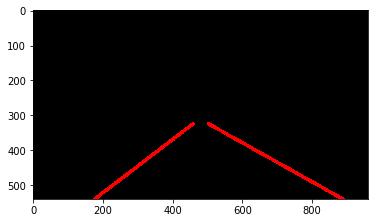

In [10]:
hough_lines_img = hough_lines(region_masked_img, 2, (np.pi / 180), 20, 25, 10)
plt.imshow(hough_lines_img)
mpimg.imsave("output_images_solidWhiteCurve/houghLinesImage.jpg", hough_lines_img)

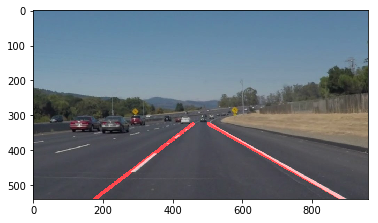

In [11]:
weighted_img = weighted_img(hough_lines_img, orig_img_copy)
plt.imshow(weighted_img)
mpimg.imsave("output_images_solidWhiteCurve/finalImage.jpg", weighted_img)